<a href="https://colab.research.google.com/github/CMedrado/Topicosemcomputa-o/blob/main/GCC_total_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Texto no contexto da Predição de Severidade de Bug Reports

Exemplo de classificação de texto com pipeline de NLP e classificador no final

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


In [2]:
# Tokenização
def tokenize(text):
    # Tokenização
    tokens = nltk.word_tokenize(text)
    
    # Stemização
    stems  = []
    for item in tokens:
        stems.append(SnowballStemmer("english").stem(item))
    return stems

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Carregando os dados
df = pd.read_csv('/content/drive/My Drive/TP/PF/Dataset (1)/GCC_total.csv') # Salvamos com esse nome antes

# Dataset
df.head(11)

,Bug_report_ID,Product_Name,summary,description,component_name,severity_level,priority,assignee_developers,topic_id,status
0,21065,classpath,javax swing event eventlistenerlist getlistene...,custom class wich throw event reli eventlisten...,swing,critical,P1,unassigned,gruni.ca gruni.ca roman konqueror tromey,FIXED
1,23557,classpath,jcombobox graphics d crash vm gtk,compil run attach testcas graphics d en classp...,swing,critical,P1,langel,hendrich hendrich fitzsim cvs-commit hendrich ...,FIXED
2,27833,classpath,strang repaint bug graphics d updat,built classpath cv linux suse upgrad gtk exper...,swing,critical,P2,roman,hendrich hendrich hendrich hendrich hendrich a...,FIXED
3,23795,classpath,implement miss function basictreeui metaltreeu...,implement miss,swing,normal,P2,langel,langel langel cvs-commit,FIXED
4,23966,classpath,jinternalfram mous move infinit loop,run testcas move mous main section jinternalfr...,swing,normal,P2,abalkiss,abalkiss abalkiss,FIXED
5,16774,classpath,box layout resiz compon fill entir space contain,bugzilla helper user ag mozilla x linux i en u...,swing,normal,P2,graydon,rodimina rodimina fitzsim fitzsim,FIXED
6,24105,classpath,gapcont properli updat posit,border case posit implement run testcas insert...,swing,normal,P2,roman,abalkiss roman roman cvs-commit,FIXED
7,20015,classpath,jmenu stay open,show jmenu work click jmenu close menu jmenu p...,swing,normal,P2,langel,hendrich hendrich fitzsim langel,FIXED
8,24316,classpath,utilities gettabbedtextoffset problem,method input point charact run testcas click t...,swing,normal,P2,abalkiss,abalkiss abalkiss abalkiss abalkiss abalkiss a...,FIXED
9,23203,classpath,jlist getlastvisibleindex incorrect,jlist getlastvisibleindex return display area ...,swing,normal,P2,abalkiss,abalkiss abalkiss,FIXED


In [5]:
df['severity_level'].value_counts()

normal         10137
critical        1664
enhancement     1141
minor            498
major            270
blocker          229
trivial           87
Name: severity_level, dtype: int64

In [6]:
class_names = df['severity_level'].unique()
class_names

array(['critical', 'normal', 'minor', 'enhancement', 'blocker', 'major',
       'trivial'], dtype=object)

In [7]:
status_names = df['status'].unique() 
status_names

array(['FIXED'], dtype=object)

In [8]:
#Convertendo 'summary' e 'description' para string
df = df.astype({'summary':'str', 'description':'str'})

In [9]:
#Filtrando severidades confiaveis
df = df.loc[(df['severity_level'] != 'enhancement') & (df['severity_level'] != 'normal')]

In [11]:
#Modificando severidade diferente de blocker (Classificação binaria)
df.loc[(df['severity_level'] != 'blocker'), 'severity_level'] = "no-blocker" 

In [12]:
df['severity_level'].value_counts()

no-blocker    2519
blocker        229
Name: severity_level, dtype: int64

In [13]:
df.head(11)

,Bug_report_ID,Product_Name,summary,description,component_name,severity_level,priority,assignee_developers,topic_id,status
0,21065,classpath,javax swing event eventlistenerlist getlistene...,custom class wich throw event reli eventlisten...,swing,no-blocker,P1,unassigned,gruni.ca gruni.ca roman konqueror tromey,FIXED
1,23557,classpath,jcombobox graphics d crash vm gtk,compil run attach testcas graphics d en classp...,swing,no-blocker,P1,langel,hendrich hendrich fitzsim cvs-commit hendrich ...,FIXED
2,27833,classpath,strang repaint bug graphics d updat,built classpath cv linux suse upgrad gtk exper...,swing,no-blocker,P2,roman,hendrich hendrich hendrich hendrich hendrich a...,FIXED
111,22616,classpath,imageicon geticonheight throw npe,step reproduc compil run attach testcas expect...,swing,no-blocker,P2,graydon,timo.lindfors timo.lindfors pinskia fitzsim,FIXED
112,24099,classpath,gdkgraphics d copyarea implement,recent swing repaint mechan reli graphics copy...,swing,no-blocker,P2,fitzsim,hendrich mark hendrich langel hendrich langel ...,FIXED
114,27297,classpath,subsequ intern frame close,th intern frame swing demo close click close i...,swing,blocker,P3,audriusa,audriusa audriusa audriusa roman audriusa audr...,FIXED
115,27326,classpath,jpopupmenu broken,download built classpath cv linux x test jamvm...,swing,blocker,P3,roman,hendrich roman cvs-commit roman hendrich,FIXED
116,29448,classpath,swing demo content resiz,run swing demo maxim frame content frame stay ...,swing,blocker,P3,roman,david.gilbert roman roman cvs-commit roman twi...,FIXED
117,24987,classpath,dialog broken,strang start dialog swing activ board dialog w...,swing,blocker,P3,roman,audriusa audriusa langel roman,FIXED
118,27973,classpath,defaultstyleddocu interoper html support imple...,code implement function htmldocument complet f...,swing,blocker,P3,roman,audriusa audriusa audriusa audriusa roman audr...,FIXED


In [14]:
df.shape[0]

2748

In [15]:
# Stop Words

nltk.download('stopwords')

nltk.download('punkt')

stop_words = nltk.corpus.stopwords.words('english')

text_clf   = Pipeline([
                # Vectorize
                ('vect',  TfidfVectorizer(tokenizer=tokenize, 
                                          stop_words=stop_words, 
                                          ngram_range=(1,1))),
                # Classificador
                ('clf',   KNeighborsClassifier(n_jobs=-5)),
            ])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Divididos em 11 quadros não sobrepostos de tamanhos iguais.

In [17]:
df_set = []
k = 249
for i in range(0,10):
  df_set.append(df.iloc[i*249:k])
  k += 249
  print("Quadro {}".format(i), "possui {} entradas.".format(df_set[i].shape[0]))

df_set.append(df.iloc[2490:2748])

print("Quadro 10 possui {} entradas.".format(df_set[10].shape[0]))

Quadro 0 possui 249 entradas.
Quadro 1 possui 249 entradas.
Quadro 2 possui 249 entradas.
Quadro 3 possui 249 entradas.
Quadro 4 possui 249 entradas.
Quadro 5 possui 249 entradas.
Quadro 6 possui 249 entradas.
Quadro 7 possui 249 entradas.
Quadro 8 possui 249 entradas.
Quadro 9 possui 249 entradas.
Quadro 10 possui 258 entradas.


In [18]:
X_test = []

for i in range(0, 10):
  new_df = df_set[0]
  for j in range(0, i):
    new_df = pd.merge(new_df, df_set[j+1], how = 'outer')
  X_test.append(new_df)

In [19]:
for i in range(0, len(X_test)):
  print("Treinamento {}, possui {} entradas.". format(i+1, X_test[i].shape[0]))

Treinamento 1, possui 249 entradas.
Treinamento 2, possui 498 entradas.
Treinamento 3, possui 747 entradas.
Treinamento 4, possui 996 entradas.
Treinamento 5, possui 1245 entradas.
Treinamento 6, possui 1494 entradas.
Treinamento 7, possui 1743 entradas.
Treinamento 8, possui 1992 entradas.
Treinamento 9, possui 2241 entradas.
Treinamento 10, possui 2490 entradas.


In [20]:
# Evaluate
for i in range(0, len(X_test)):
  text_clf = text_clf.fit(X_test[i].description, X_test[i].assignee_developers)
  pred = text_clf.predict(df_set[i+1].description)
  accuracy_scoreMLP_TFIDF = f1_score(df_set[i+1].assignee_developers, pred, average='micro')
  accuracy_scoreMLP_TFIDF

In [ ]:

predictions = text_clf.predict(df_set[10].description)

conf_matrix = confusion_matrix(df_set[10].assignee_developers, predictions)

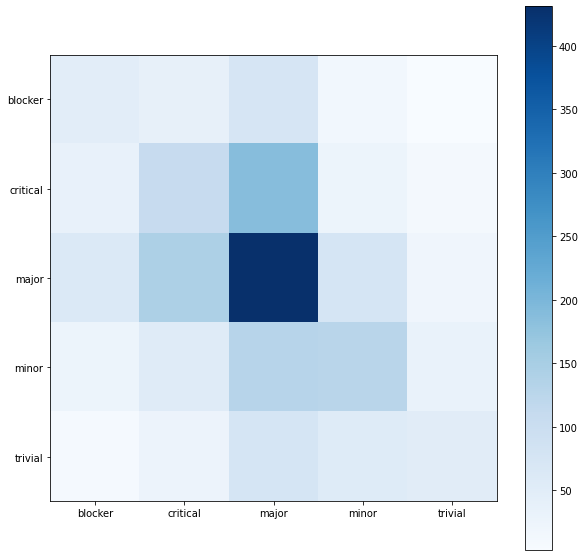

In [ ]:
plt.figure(figsize=(10,10))
plt.xticks(np.arange(len(text_clf.classes_)),text_clf.classes_)
plt.yticks(np.arange(len(text_clf.classes_)),text_clf.classes_)
plt.imshow(conf_matrix,cmap=plt.cm.Blues)
plt.colorbar()